Sri Sankeerth Koduru- 0768993

In [ ]:
# Data processing libraries
import pandas as pd
import numpy as np
#import itertools

# Stats libraries
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#import scipy.stats

# Image libraries
import matplotlib.pyplot as plt


# Make pandas dataframes prettier
#from IPython.display import display, HTML

# Access data using Google BigQuery.
import os
from google.colab import auth
from google.cloud import bigquery

In [ ]:
!pip install tableone
from tableone import TableOne

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
auth.authenticate_user()

In [ ]:
project_id='physionet-data-295222'
#Type in your respective project ID from google cloud big query
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

In [ ]:
%%bigquery data

WITH first_icu AS (
    SELECT i.subject_id, i.hadm_id, i.icustay_id, i.gender, i.admittime admittime_hospital,
      i.dischtime dischtime_hospital, i.los_hospital, i.admission_age, i.ethnicity,
      i.hospital_expire_flag, i.intime intime_icu, i.outtime outtime_icu, i.los_icu,
      s.first_careunit, a.admission_type
    FROM physionet-data.mimiciii_derived.icustay_detail i
    LEFT JOIN physionet-data.mimiciii_clinical.icustays s
    ON i.icustay_id = s.icustay_id
    LEFT JOIN physionet-data.mimiciii_clinical.admissions a
    ON i.hadm_id = a.hadm_id
    WHERE i.hospstay_seq = 1
      AND i.icustay_seq = 1
      AND i.admission_age >= 16
)
SELECT f.*, o.icustay_expire_flag, o.oasis, o.oasis_prob
FROM first_icu f
LEFT JOIN physionet-data.mimiciii_derived.oasis o
ON f.icustay_id = o.icustay_id;


In [ ]:
%%bigquery data1
with ce as
(
  select
    icustay_id, charttime, itemid, valuenum
  from physionet-data.mimiciii_clinical.chartevents
  -- specify what data we want from chartevents
  where itemid in
  (
  211, -- Heart Rate
  618, --	Respiratory Rate
  615 --	Resp Rate (Total)
  )
  -- how did we know heart rates were stored using ITEMID 211? Simple, we looked in D_ITEMS!
  -- Try it for yourself: select * from d_items where lower(label) like '%heart rate%'
)
select
  -- ICUSTAY_ID identifies each unique patient ICU stay
  -- note that if the same person stays in the ICU more than once, each stay would have a *different* ICUSTAY_ID
  -- however, since it's the same person, all those stays would have the same SUBJECT_ID
  ie.icustay_id

  -- this is the outcome of interest: in-hospital mortality
  , max(adm.HOSPITAL_EXPIRE_FLAG) as OUTCOME

  -- this is a case statement - essentially an "if, else" clause
  , min(
      case
        -- if the itemid is 211
        when itemid = 211
          -- then return the actual value stored in VALUENUM
          then valuenum
        -- otherwise, return 'null', which is SQL standard for an empty value
        else null
      -- end the case statement
      end
    ) as HeartRate_Min

    -- note we wrapped the above in "min()"
    -- this takes the minimum of all values inside, and *ignores* nulls
    -- by calling this on our case statement, we are ignoring all values except those with ITEMID = 211
    -- since ITEMID 211 are heart rates, we take the minimum of only heart rates

  , max(case when itemid = 211 then valuenum else null end) as HeartRate_Max
  , min(case when itemid in (615,618) then valuenum else null end) as RespRate_Min
  , max(case when itemid in (615,618) then valuenum else null end) as RespRate_Max
from physionet-data.mimiciii_clinical.icustays ie

-- join to the admissions table to get hospital outcome
inner join physionet-data.mimiciii_clinical.admissions adm
  on ie.hadm_id = adm.hadm_id

-- join to the chartevents table to get the observations
left join ce
  -- match the tables on the patient identifier
  on ie.icustay_id = ce.icustay_id
  -- and require that the observation be made after the patient is admitted to the ICU
  and ce.charttime >= ie.intime
  -- and *before* their admission time + 1 day, i.e. the observation must be made on their first day in the ICU
  and ce.charttime <= DATETIME_ADD(ie.intime, INTERVAL 1 DAY)
group by ie.icustay_id
order by ie.icustay_id;

In [ ]:
data.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'admittime_hospital',
       'dischtime_hospital', 'los_hospital', 'admission_age', 'ethnicity',
       'hospital_expire_flag', 'intime_icu', 'outtime_icu', 'los_icu',
       'first_careunit', 'admission_type', 'icustay_expire_flag', 'oasis',
       'oasis_prob'],
      dtype='object')

In [ ]:
data.to_csv('data.csv')

In [ ]:
data.shape #(38558, 23)

(38558, 18)

In [ ]:
data.head()

,subject_id,hadm_id,icustay_id,gender,admittime_hospital,dischtime_hospital,los_hospital,admission_age,ethnicity,hospital_expire_flag,intime_icu,outtime_icu,los_icu,first_careunit,admission_type,icustay_expire_flag,oasis,oasis_prob
0,3,145834,211552,M,2101-10-20 19:08:00,2101-10-31 13:58:00,11,76,WHITE,0,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0,MICU,EMERGENCY,0,57,0.748927
1,6,107064,228232,F,2175-05-30 07:15:00,2175-06-15 16:00:00,16,66,WHITE,0,2175-05-30 21:30:54,2175-06-03 13:39:54,4.0,SICU,ELECTIVE,0,11,0.008392
2,56,181711,275642,F,2104-01-02 02:01:00,2104-01-08 10:30:00,6,300,WHITE,1,2104-01-02 02:02:39,2104-01-03 22:25:29,1.0,SICU,EMERGENCY,0,52,0.611922
3,98,188606,216929,F,2137-04-02 08:00:00,2137-04-09 10:38:00,7,41,WHITE,0,2137-04-02 15:15:39,2137-04-04 21:06:16,2.0,SICU,ELECTIVE,0,11,0.008392
4,136,184644,203947,M,2103-05-09 07:15:00,2103-05-14 11:33:00,5,52,WHITE,0,2103-05-09 18:17:36,2103-05-10 16:42:19,1.0,SICU,ELECTIVE,0,8,0.005740


In [ ]:
data.tail()

,subject_id,hadm_id,icustay_id,gender,admittime_hospital,dischtime_hospital,los_hospital,admission_age,ethnicity,hospital_expire_flag,intime_icu,outtime_icu,los_icu,first_careunit,admission_type,icustay_expire_flag,oasis,oasis_prob
38553,97769,186629,227000,F,2120-03-13 21:53:00,2120-03-23 14:36:00,10,82,WHITE,0,2120-03-15 10:01:37,2120-03-20 15:32:55,5.0,MICU,EMERGENCY,0,49,0.518217
38554,97976,121528,234574,M,2174-04-12 12:31:00,2174-05-09 15:05:00,27,37,BLACK/AFRICAN AMERICAN,0,2174-04-12 12:32:11,2174-04-16 17:52:15,4.0,TSICU,EMERGENCY,0,49,0.518217
38555,98584,163688,246220,F,2102-01-30 08:13:00,2102-02-25 17:59:00,26,87,WHITE,0,2102-01-30 08:14:08,2102-02-03 02:43:07,4.0,MICU,EMERGENCY,0,49,0.518217
38556,99260,181010,206662,M,2190-12-20 00:30:00,2191-01-05 18:00:00,16,52,WHITE,0,2190-12-20 00:31:17,2191-01-05 18:05:55,16.0,MICU,EMERGENCY,0,49,0.518217
38557,99339,161492,254639,M,2145-10-14 02:26:00,2145-10-19 16:00:00,5,77,ASIAN,0,2145-10-14 16:24:05,2145-10-16 19:41:45,2.0,SICU,EMERGENCY,0,49,0.518217


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38558 entries, 0 to 38557
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   subject_id            38558 non-null  int64         
 1   hadm_id               38558 non-null  int64         
 2   icustay_id            38558 non-null  int64         
 3   gender                38558 non-null  object        
 4   admittime_hospital    38558 non-null  datetime64[ns]
 5   dischtime_hospital    38558 non-null  datetime64[ns]
 6   los_hospital          38558 non-null  int64         
 7   admission_age         38558 non-null  int64         
 8   ethnicity             38558 non-null  object        
 9   hospital_expire_flag  38558 non-null  int64         
 10  intime_icu            38558 non-null  datetime64[ns]
 11  outtime_icu           38556 non-null  datetime64[ns]
 12  los_icu               38556 non-null  float64       
 13  first_careunit  

In [ ]:
data.describe()

,subject_id,hadm_id,icustay_id,los_hospital,admission_age,hospital_expire_flag,los_icu,icustay_expire_flag,oasis,oasis_prob
count,38558.000000,38558.000000,38558.000000,38558.000000,38558.000000,38558.000000,38556.000000,38558.000000,38558.000000,38558.000000
mean,38266.820037,150037.148919,250222.157218,9.853831,74.562970,0.114736,3.987395,0.082836,31.225582,0.144295
std,29376.431490,28944.929045,28913.703899,10.705233,55.115176,0.318708,6.018559,0.275638,8.962683,0.143488
min,3.000000,100001.000000,200003.000000,0.000000,16.000000,0.000000,0.000000,0.000000,3.000000,0.003042
25%,13980.250000,124928.500000,225240.250000,4.000000,52.000000,0.000000,1.000000,0.000000,25.000000,0.048012
50%,27912.500000,150092.500000,250278.000000,7.000000,66.000000,0.000000,2.000000,0.000000,31.000000,0.097783
75%,62963.250000,175222.250000,275287.000000,12.000000,78.000000,0.000000,4.000000,0.000000,37.000000,0.188911
max,99999.000000,199999.000000,299999.000000,295.000000,310.000000,1.000000,154.000000,1.000000,70.000000,0.939936


In [ ]:
data['admitday_hospital'] = data.admittime_hospital.dt.dayofweek
data['dischday_hospital'] = data.dischtime_hospital.dt.dayofweek
data['inday_icu'] = data.intime_icu.dt.dayofweek
data['inday_icu_seq'] = data.intime_icu.dt.dayofweek
data['outday_icu'] = data.outtime_icu.dt.dayofweek
data.head()

,subject_id,hadm_id,icustay_id,gender,admittime_hospital,dischtime_hospital,los_hospital,admission_age,ethnicity,hospital_expire_flag,intime_icu,outtime_icu,los_icu,first_careunit,admission_type,icustay_expire_flag,oasis,oasis_prob,admitday_hospital,dischday_hospital,inday_icu,inday_icu_seq,outday_icu
0,3,145834,211552,M,2101-10-20 19:08:00,2101-10-31 13:58:00,11,76,WHITE,0,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0,MICU,EMERGENCY,0,57,0.748927,3,0,3,3,2.0
1,6,107064,228232,F,2175-05-30 07:15:00,2175-06-15 16:00:00,16,66,WHITE,0,2175-05-30 21:30:54,2175-06-03 13:39:54,4.0,SICU,ELECTIVE,0,11,0.008392,1,3,1,1,5.0
2,56,181711,275642,F,2104-01-02 02:01:00,2104-01-08 10:30:00,6,300,WHITE,1,2104-01-02 02:02:39,2104-01-03 22:25:29,1.0,SICU,EMERGENCY,0,52,0.611922,2,1,2,2,3.0
3,98,188606,216929,F,2137-04-02 08:00:00,2137-04-09 10:38:00,7,41,WHITE,0,2137-04-02 15:15:39,2137-04-04 21:06:16,2.0,SICU,ELECTIVE,0,11,0.008392,1,1,1,1,3.0
4,136,184644,203947,M,2103-05-09 07:15:00,2103-05-14 11:33:00,5,52,WHITE,0,2103-05-09 18:17:36,2103-05-10 16:42:19,1.0,SICU,ELECTIVE,0,8,0.005740,2,0,2,2,3.0


In [ ]:
data['inday_icu'].value_counts()

4    6263
1    6141
0    6097
2    5985
3    5877
5    4235
6    3960
Name: inday_icu, dtype: int64

In [ ]:
# create weekday vs weekend column for icu_intime
data['inday_icu_wkd'] = np.where(data.intime_icu.dt.weekday <= 4,
                                 'weekday','weekend')
data['inday_icu_wkd'].value_counts()

weekday    30363
weekend     8195
Name: inday_icu_wkd, dtype: int64

In [ ]:
data.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'admittime_hospital',
       'dischtime_hospital', 'los_hospital', 'admission_age', 'ethnicity',
       'hospital_expire_flag', 'intime_icu', 'outtime_icu', 'los_icu',
       'first_careunit', 'admission_type', 'icustay_expire_flag', 'oasis',
       'oasis_prob', 'admitday_hospital', 'dischday_hospital', 'inday_icu',
       'inday_icu_seq', 'outday_icu', 'inday_icu_wkd'],
      dtype='object')

In [ ]:
data.head

<bound method NDFrame.head of        subject_id  hadm_id  icustay_id  ... inday_icu_seq outday_icu inday_icu_wkd
0               3   145834      211552  ...             3        2.0       weekday
1               6   107064      228232  ...             1        5.0       weekday
2              56   181711      275642  ...             2        3.0       weekday
3              98   188606      216929  ...             1        3.0       weekday
4             136   184644      203947  ...             2        3.0       weekday
...           ...      ...         ...  ...           ...        ...           ...
38553       97769   186629      227000  ...             4        2.0       weekday
38554       97976   121528      234574  ...             1        5.0       weekday
38555       98584   163688      246220  ...             0        4.0       weekday
38556       99260   181010      206662  ...             0        2.0       weekday
38557       99339   161492      254639  ...             3

In [ ]:
columns = ['gender', 'los_hospital', 'admission_age', 'admission_type', 'hospital_expire_flag',
           'los_icu','icustay_expire_flag', 'oasis', 'oasis_prob', 'first_careunit',
           'inday_icu_wkd']

groupby = 'inday_icu'

pval = False

categorical = ['gender','admission_type','hospital_expire_flag','icustay_expire_flag',
               'first_careunit','inday_icu_wkd']

t = TableOne(data, columns=columns, categorical=categorical, groupby=groupby, pval=pval)
t.tableone

Grouped by inday_icu  ...              
                                                   Missing  ...             6
n                                                           ...          3960
gender, n (%)               F                            0  ...   1736 (43.8)
                            M                               ...   2224 (56.2)
los_hospital, mean (SD)                                  0  ...    9.8 (10.7)
admission_age, mean (SD)                                 0  ...   75.3 (60.7)
admission_type, n (%)       ELECTIVE                     0  ...     101 (2.6)
                            EMERGENCY                       ...   3681 (93.0)
                            URGENT                          ...     178 (4.5)
hospital_expire_flag, n (%) 0                            0  ...   3388 (85.6)
                            1                               ...    572 (14.4)
los_icu, mean (SD)                                       2  ...     4.3 (6.3)
icustay_expire_flag, n (%)  0                            0  ...   3548 (89.6)
                            1                               ...    412 (10.4)
oasis, mean (SD)                                         0  ...    32.1 (9.0)
oasis_prob, mean (SD)                                    0  ...     0.2 (0.2)
first_careunit, n (%)       CCU                          0  ...    621 (15.7)
                            CSRU                            ...     194 (4.9)
                            MICU                            ...   1706 (43.1)
                            SICU                            ...    743 (18.8)
                            TSICU                           ...    696 (17.6)
inday_icu_wkd, n (%)        weekday                      0  ...              
                            weekend                         ...  3960 (100.0)

[22 rows x 9 columns]

In [ ]:
columns = ['gender', 'los_hospital', 'admission_age', 'admission_type', 'hospital_expire_flag',
           'los_icu','icustay_expire_flag', 'oasis', 'oasis_prob', 'first_careunit']

groupby = 'inday_icu_wkd'

pval = False

categorical = ['gender','admission_type','hospital_expire_flag','icustay_expire_flag',
               'first_careunit']

t = TableOne(data, columns=columns, categorical=categorical, groupby=groupby, pval=pval)
t.tableone

Grouped by inday_icu_wkd  ...             
                                                       Missing  ...      weekend
n                                                               ...         8195
gender, n (%)               F                                0  ...  3593 (43.8)
                            M                                   ...  4602 (56.2)
los_hospital, mean (SD)                                      0  ...   9.9 (10.8)
admission_age, mean (SD)                                     0  ...  74.6 (59.6)
admission_type, n (%)       ELECTIVE                         0  ...    263 (3.2)
                            EMERGENCY                           ...  7533 (91.9)
                            URGENT                              ...    399 (4.9)
hospital_expire_flag, n (%) 0                                0  ...  7046 (86.0)
                            1                                   ...  1149 (14.0)
los_icu, mean (SD)                                           2  ...    4.3 (6.4)
icustay_expire_flag, n (%)  0                                0  ...  7359 (89.8)
                            1                                   ...   836 (10.2)
oasis, mean (SD)                                             0  ...   31.8 (9.1)
oasis_prob, mean (SD)                                        0  ...    0.2 (0.2)
first_careunit, n (%)       CCU                              0  ...  1316 (16.1)
                            CSRU                                ...    431 (5.3)
                            MICU                                ...  3471 (42.4)
                            SICU                                ...  1486 (18.1)
                            TSICU                               ...  1491 (18.2)

[20 rows x 4 columns]

In [ ]:
# Pivot data to summarise by day
dat_dow = data.groupby(['admission_type',
                        'inday_icu_seq'])['hospital_expire_flag'].mean().reset_index()

dat_dow = dat_dow.pivot(index='inday_icu_seq',
                        columns='admission_type', values='hospital_expire_flag')

dat_dow

admission_type,ELECTIVE,EMERGENCY,URGENT
inday_icu_seq,,,
0,0.020553,0.124387,0.137931
1,0.019350,0.130315,0.082759
2,0.026549,0.127391,0.112676
3,0.027027,0.133137,0.114504
4,0.026575,0.126612,0.093023
5,0.080247,0.137072,0.162896
6,0.089109,0.146971,0.123596


Text(0, 0.5, 'Hospital mortality rate')

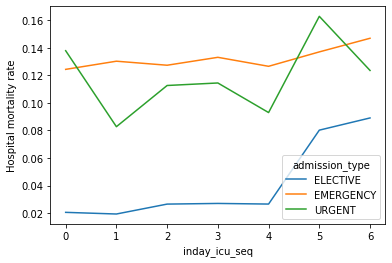

In [ ]:
# day_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
ax = dat_dow.plot()
ax.set_ylabel("Hospital mortality rate")

In [ ]:
dat_wkd = data.groupby(['admission_type','inday_icu_wkd'])['hospital_expire_flag'].mean().reset_index()
dat_wkd = dat_wkd.pivot(index='inday_icu_wkd', columns='admission_type', values='hospital_expire_flag')
dat_wkd.head()

admission_type,ELECTIVE,EMERGENCY,URGENT
inday_icu_wkd,,,
weekday,0.023732,0.128353,0.108382
weekend,0.083650,0.141909,0.145363


Text(0, 0.5, 'Hospital mortality rate')

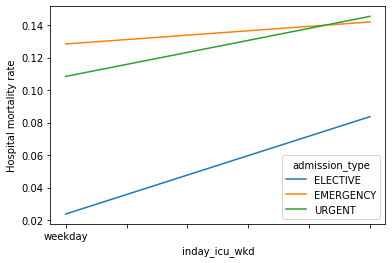

In [ ]:
ax = dat_wkd.plot()
ax.set_ylabel("Hospital mortality rate")

In [ ]:
# Perform Correlation using correlation matrix

In [ ]:
# Heatmap

In [ ]:
# Train-Test Split

In [ ]:
# Fit the Logistic Regression Model

In [ ]:
#Confusion Matrix with total number of values

In [ ]:
# Find Accuracy, Precision, Recall and F1-score

In [ ]:
# Comment on the model performance

In [ ]:
# Do patients admitted on a weekend have a higher rate of mortality than those admitted during the week?
#Explain here in a short paragraph

#### QUESTION: Think of impact of different days of week on Mortality rate

Ans:

Day of the Week VS Mortality Rate:

-> Elective: There are very few mortality on elective admission into the hospital from monday to Friday. On saturday there is a huge rise in the mortality rate and sunday has the highest mortality rate for elective admission into a hispital.

-> Emergency: There is about a 12% mortality rate and there is a slight increase as we go from monday to sunday.

-> Urgent: There is no trend per say in this category but the highest mortality rate is on saturday at about 16% followed by monday. On the other hand, the lowest mortality rate is on tuesday at about 8% and this is followed by Friday.

Weekend and Weekday VS Mortality Rate:

->There is an increas in the mortality rate on the weekends in all 3 types of admittion into the hospital with the highest mortality on the weekend being with the urgent admission and the lowest being the elective admission type. On the other hand, for the weekdays the Emergency has the highest mortality rate and elective has the lowest mortality rate.